#### **Problem 1**
Access Stock Trading, Financial Statements and Financial Indicators databases on CSMAR and download the following data for all listed firms in the A-share market.

Ⅰ Monthly stock prices, stock returns, market value of tradable shares from Jan. 2000 to Sep. 2023;

Ⅱ Quarterly total assets, total liabilities, earnings per share, ROA (return on asset), ROE (return on equity), R&D expenses from
2000Q1 to 2023Q3; 

Ⅲ Establishment date and market type.

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

monthly_data = pd.read_csv("data/monthly_data/TRD_Mnth.csv")
balance = pd.read_csv("data/finstate/FS_Combas.csv")
rdexpense = pd.read_csv("data/finstate/FS_Comins.csv")
eps = pd.read_csv("data/eps/FI_T9.csv")
earn_capacity = pd.read_csv("data/earn_capacity/FI_T5.csv")
comp_profile = pd.read_csv("data/comp_profile/TRD_Co.csv")

a. Calculate monthly P/E ratios (stock price/earnings per share), monthly P/B ratios (stock price/book value per share), quarterly R&D expense/total asset ratios and quarterly firm ages (current date - establishment date).

In [67]:
"""Derive monthly P/E ratios"""

# Adjust variables.
monthly_data.columns = ["code", "trade_month", "price", "mktvalue", "return"] 
eps = eps.drop(columns = ["ShortName_EN"])
eps = eps[eps["Typrep"] != "B"]
eps.columns = ["code", "trade_date", "statetype", "eps"]

# Transform the date into comparable form.
monthly_data["date"] = pd.to_datetime(monthly_data["trade_month"])
monthly_data["date"] = monthly_data["date"].dt.to_period("M")
eps["date"] = pd.to_datetime(eps["trade_date"])
eps["date"] = (eps["date"] + pd.DateOffset(months=1)).dt.to_period("M")

# Merge monthly_data and eps.
merged_1 = pd.merge(monthly_data, eps, how = "left", on = ["code", "date"])
merged_1["eps"] = merged_1.groupby("code")["eps"].ffill()
merged_1 = merged_1.dropna(subset=["eps"])

# Calculate P/E.
merged_1["pe_ratio"] = merged_1["price"] / merged_1["eps"]
merged_1 = merged_1.drop(columns = ["trade_month", "trade_date", "statetype"])
print(merged_1)


          code   price     mktvalue    return     date       eps   pe_ratio
6            1   18.51  19822404.83  0.020960  2000-07  0.317187  58.356742
7            1   17.75  19008518.95 -0.041059  2000-08  0.317187  55.960679
8            1   16.96  18162505.99 -0.044507  2000-09  0.317187  53.470035
9            1   17.55  18794338.45  0.034788  2000-10  0.317187  55.330136
10           1   15.49  21579502.59  0.010403  2000-11  0.317187  48.835545
...        ...     ...          ...       ...      ...       ...        ...
679943  873593  101.20   1818084.41  0.581250  2023-05  3.275207  30.898810
679944  873593  133.40   2396565.82  0.318182  2023-06  3.275207  40.730250
679945  873593   86.00   1545012.45 -0.355322  2023-07  2.093781  41.074019
679946  873593   77.50   1392307.73 -0.098837  2023-08  2.093781  37.014377
679947  873593   36.06   1295654.62 -0.057085  2023-09  2.093781  17.222432

[654404 rows x 7 columns]


In [68]:
"""Derive monthly P/B ratios"""

# Adjust variables.
earn_capacity = earn_capacity.drop(columns = ["ShortName_EN"])
earn_capacity = earn_capacity[earn_capacity["Typrep"] != "B"]
earn_capacity.columns = ["code", "record_date", "statetype", "ROA", "ROE"]

# Transform the date into comparable form.
earn_capacity["date"] = pd.to_datetime(earn_capacity["record_date"])
earn_capacity["date"] = (earn_capacity["date"] + pd.DateOffset(months=1)).dt.to_period("M")

# Merge merged_1 and earn_capacity.
merged_2 = pd.merge(merged_1, earn_capacity, how = "left", on = ["code", "date"])
merged_2["ROE"] = merged_2.groupby("code")["ROE"].ffill()
merged_2 = merged_2.dropna(subset = ["ROE"])

# Calculate P/B.
merged_2["pb_ratio"] = merged_2["pe_ratio"] * merged_2["ROE"]
merged_2 = merged_2.drop(columns = ["price", "mktvalue", "eps",\
                                    "record_date", "statetype"])
print(merged_2)


          code    return     date   pe_ratio       ROA       ROE  pb_ratio
0            1  0.020960  2000-07  58.356742  0.003578  0.057805  3.373311
1            1 -0.041059  2000-08  55.960679       NaN  0.057805  3.234807
2            1 -0.044507  2000-09  53.470035       NaN  0.057805  3.090835
3            1  0.034788  2000-10  55.330136       NaN  0.057805  3.198359
4            1  0.010403  2000-11  48.835545       NaN  0.057805  2.822939
...        ...       ...      ...        ...       ...       ...       ...
654399  873593  0.581250  2023-05  30.898810       NaN  0.123005  3.800708
654400  873593  0.318182  2023-06  40.730250       NaN  0.123005  5.010024
654401  873593 -0.355322  2023-07  41.074019  0.071695  0.078817  3.237331
654402  873593 -0.098837  2023-08  37.014377       NaN  0.078817  2.917362
654403  873593 -0.057085  2023-09  17.222432       NaN  0.078817  1.357420

[654240 rows x 7 columns]


In [69]:
"""Derive quarterly R&D expense/total asset ratios"""

# Adjust variables.
balance = balance[balance["Typrep"] != "B"]
balance = balance.drop(columns = ["Typrep"])
balance.columns = ["code", "name", "record_date", "assets", "liabilities"]

rdexpense = rdexpense.drop(columns = ["ShortName_EN"])
rdexpense = rdexpense[rdexpense["Typrep"] != "B"]
rdexpense = rdexpense.drop(columns = ["Typrep"])
rdexpense.columns = ["code", "record_date", "rdexpense"]

# Merge balance and rdexpense.
merged_3 = pd.merge(balance, rdexpense, how = "left", on = ["code", "record_date"])
merged_3["record_date"] = pd.to_datetime(merged_3["record_date"]).dt.to_period("Q")
merged_3 = merged_3.dropna(subset = ["rdexpense"])

# Calculate E/A.
merged_3["ea_ratio"] = merged_3["rdexpense"] / merged_3["assets"]
print(merged_3)


          code  name record_date        assets   liabilities     rdexpense  \
201          2   WKA      2018Q1  1.165347e+12  9.786730e+11  6.133269e+08   
204          2   WKA      2018Q3  1.432222e+12  1.216330e+12  3.751533e+08   
205          2   WKA      2018Q4  1.528579e+12  1.292959e+12  9.460644e+08   
206          2   WKA      2019Q1  1.528579e+12  1.292959e+12  9.460644e+08   
207          2   WKA      2019Q1  1.551166e+12  1.314977e+12  1.189922e+08   
...        ...   ...         ...           ...           ...           ...   
298571  873833  MXYS      2022Q2  7.047750e+08  2.470411e+08  4.978197e+06   
298572  873833  MXYS      2022Q4  7.068130e+08  2.272433e+08  9.349068e+06   
298573  873833  MXYS      2023Q1  7.068130e+08  2.272434e+08  9.349068e+06   
298574  873833  MXYS      2023Q1  6.818401e+08  1.914368e+08  2.245195e+06   
298575  873833  MXYS      2023Q2  7.027849e+08  1.995230e+08  4.953029e+06   

        ea_ratio  
201     0.000526  
204     0.000262  
205   

In [70]:
"""Derive quarterly firm ages"""

# Adjust variables.
balance["record_date"] = pd.to_datetime(balance["record_date"])
comp_profile.columns = ["code", "name", "list", "establish", "type"]
comp_profile["establish"] = pd.to_datetime(comp_profile["establish"])

# Merge balance and comp_profile.
merged_4 = pd.merge(balance, comp_profile, how = "left", on = ["code", "name"])
merged_4 = merged_4.dropna(subset = ["record_date", "establish"])

# Calculate firm ages.
merged_4["age"] = (merged_4["record_date"] - merged_4["establish"]).dt.days
merged_4 = merged_4[merged_4["age"] >= 0]
merged_4["record_date"] = merged_4["record_date"].dt.to_period("Q")
merged_4 = merged_4.drop(columns = ["assets", "liabilities", "type"])
print(merged_4)


          code  name record_date        list  establish   age
6886        96  GJNY      2000Q1  2000-07-24 1999-02-18   317
6887        96  GJNY      2000Q2  2000-07-24 1999-02-18   498
6888        96  GJNY      2000Q4  2000-07-24 1999-02-18   682
6889        96  GJNY      2001Q1  2000-07-24 1999-02-18   683
6890        96  GJNY      2001Q2  2000-07-24 1999-02-18   863
...        ...   ...         ...         ...        ...   ...
298506  873665  KQGF      2022Q4  2023-09-26 2001-08-23  7800
298507  873665  KQGF      2023Q1  2023-09-26 2001-08-23  7801
298508  873665  KQGF      2023Q1  2023-09-26 2001-08-23  7890
298509  873665  KQGF      2023Q2  2023-09-26 2001-08-23  7981
298510  873665  KQGF      2023Q3  2023-09-26 2001-08-23  8073

[158089 rows x 6 columns]


b. Summary statistics for monthly stock returns, P/E ratios, P/B ratios and quarterly ROA, ROE, R&D expense/total asset ratios, firm ages by market type (i.e., main board v.s. GEM board).

In [71]:
# Return.
merged_return = pd.merge(monthly_data, comp_profile, \
                         how = "left", on = ["code"])
main_return = merged_return[merged_return["type"].isin([1, 4, 64])]
GEM_return = merged_return[merged_return["type"].isin([16, 32])]

main_return["return"].describe()
GEM_return["return"].describe()


count    113574.000000
mean          0.012296
std           0.181764
min          -0.863517
25%          -0.084442
50%          -0.004852
75%           0.081081
max           6.399758
Name: return, dtype: float64

In [72]:
# P/E.
merged_pe = pd.merge(merged_1, comp_profile, \
                     how = "left", on = ["code"])

main_pe = merged_pe[merged_pe["type"].isin([1, 4, 64])]
GEM_pe = merged_pe[merged_pe["type"].isin([16, 32])]

main_pe["pe_ratio"].describe()
GEM_pe["pe_ratio"].describe()


count    1.076010e+05
mean     9.524540e+01
std      1.062714e+04
min     -6.928571e+05
25%      2.439993e+01
50%      4.196181e+01
75%      7.202734e+01
max      2.087500e+06
Name: pe_ratio, dtype: float64

In [73]:
# P/B.
merged_pb = pd.merge(merged_2, comp_profile, \
                     how = "left", on = ["code"])

main_pb = merged_pb[merged_pb["type"].isin([1, 4, 64])]
GEM_pb = merged_pb[merged_pb["type"].isin([16, 32])]

main_pb["pb_ratio"].describe()
GEM_pb["pb_ratio"].describe()

count    107601.000000
mean          4.221515
std         267.775554
min       -5368.593377
25%           0.730826
50%           1.897678
75%           3.610089
max       52705.200000
Name: pb_ratio, dtype: float64

In [74]:
# ROA/ROE.
merged_roae = pd.merge(earn_capacity, comp_profile, \
                     how = "left", on = ["code"])

main_roae = merged_roae[merged_roae["type"].isin([1, 4, 64])]
GEM_roae = merged_roae[merged_roae["type"].isin([16, 32])]

main_roae[["ROA", "ROE"]].describe()
GEM_roae[["ROA", "ROE"]].describe()

,ROA,ROE
count,48755.000000,48586.000000
mean,0.038664,0.046851
std,0.086581,0.726637
min,-4.599159,-96.503985
25%,0.008830,0.013597
50%,0.028764,0.042652
75%,0.062804,0.093066
max,0.789277,77.125341


In [75]:
# R&D expense / Total assets.
merged_ea = pd.merge(merged_3, comp_profile, \
                     how = "left", on = ["code"])

main_ea = merged_ea[merged_ea["type"].isin([1, 4, 64])]
GEM_ea = merged_ea[merged_ea["type"].isin([16, 32])]

main_ea["ea_ratio"].describe()
GEM_ea["ea_ratio"].describe()


count    33970.000000
mean         0.024883
std          0.034907
min         -0.001571
25%          0.008797
50%          0.017703
75%          0.030987
max          2.695974
Name: ea_ratio, dtype: float64

In [76]:
# Firm ages.
merged_fa = pd.merge(merged_4, comp_profile, \
                     how = "left", on = ["code"])

main_fa = merged_fa[merged_fa["type"].isin([1, 4, 64])]
GEM_fa = merged_fa[merged_fa["type"].isin([16, 32])]

main_fa["age"].describe()
GEM_fa["age"].describe()


count    44581.000000
mean      6143.410444
std       2004.163499
min        164.000000
25%       4722.000000
50%       6068.000000
75%       7414.000000
max      15538.000000
Name: age, dtype: float64

#### **Problem 2**
Leveraging the data from problem 1, plot two time-series for median P/E ratio by market type.

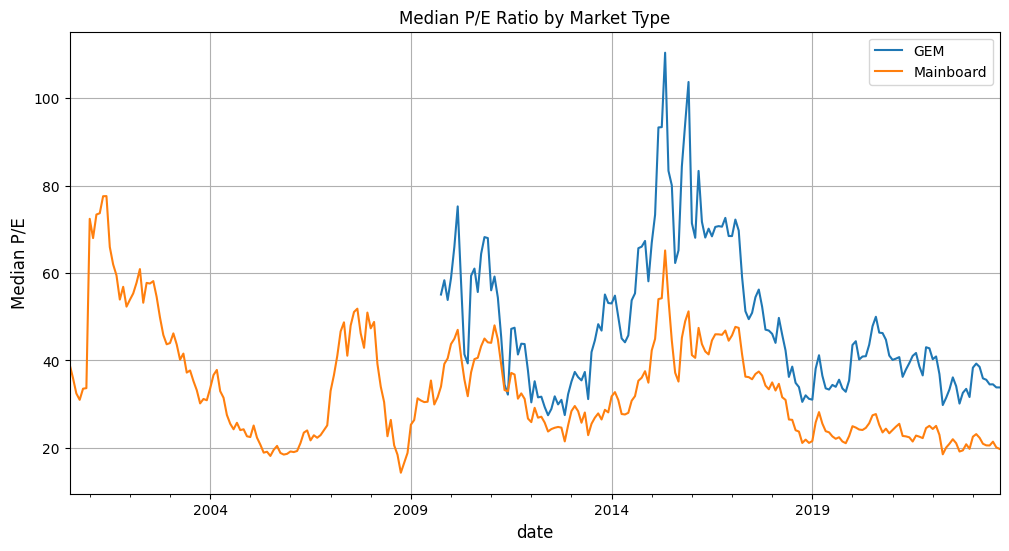

In [77]:
merged_pe["type"] = merged_pe["type"].replace([1, 4, 64], "Mainboard")
merged_pe["type"] = merged_pe["type"].replace([16, 32], "GEM")

pe_table = merged_pe.groupby(["type", "date"])["pe_ratio"].median()
pe_table = pe_table.unstack(level = 0)

# Picture.
pe_table.plot(figsize = (12, 6))
plt.title("Median P/E Ratio by Market Type", fontsize = 12)
plt.xlabel("date", fontsize = 12)
plt.ylabel("Median P/E", fontsize = 12)
plt.legend()
plt.grid(True)

plt.show()

#### **Problem 3**
Use the data from problem3_data.csv to calculate annual median values for ROE and the total revenue growth rate for each year from 2011 to 2020.Then plot two time-series illustrating the percentages of companies that consistently maintain above-median ROE and total revenue growth rate over 2011 to 2020, respectively.

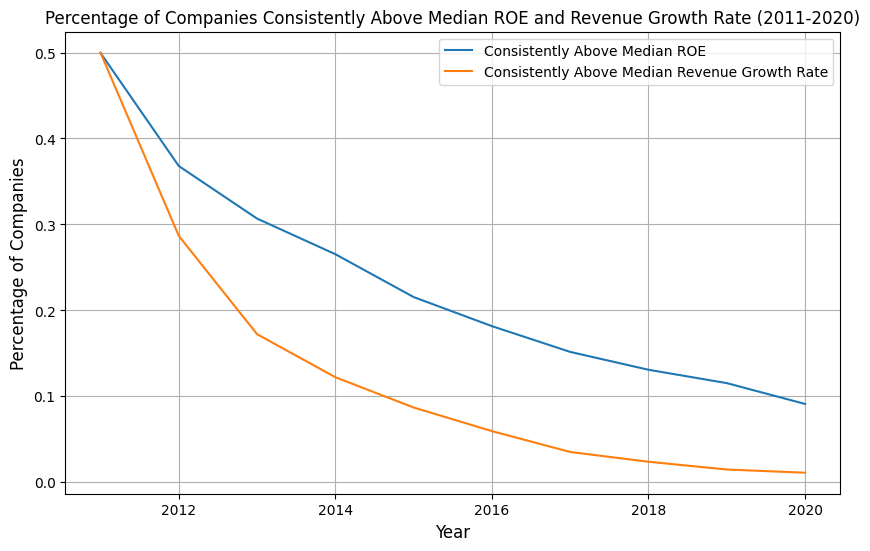

In [78]:
def custom_pct_change(series):

    shifted = series.shift(1)
    result = (series - shifted) / shifted
    result[shifted.isna()] = None 
    
    return result

p3_data = pd.read_csv("data/as1_p3.csv")

p3_data.columns = ["code", "year", "revenue", "ROE"]
p3_data["year"] = pd.to_datetime(p3_data["year"]).dt.year
years_to_keep = range(2010, 2021)
p3_data = p3_data[p3_data["year"].isin(years_to_keep)]

# Calculate median growth rate.
p3_data["rate"] = p3_data.groupby("code")["revenue"].transform(custom_pct_change)
med_rate = p3_data.groupby("year")["rate"].median().reset_index()
med_rate.columns = ["year", "med_rate"]

# Indicate above median growth.
p3_1 = p3_data.dropna(subset = "rate")
p3_1 = pd.merge(p3_1, med_rate, how="left", on="year")
p3_1["above_med_rate"] = p3_1["rate"] > p3_1["med_rate"]

p3_data = p3_data[p3_data["year"] != 2010]
p3_2 = p3_data.dropna(subset = ["ROE"])

# Calculate median ROE.
med_ROE = p3_2.groupby("year")["ROE"].median().reset_index()
med_ROE.columns = ["year", "med_ROE"]

# Indicate above median ROE.
p3_2 = pd.merge(p3_2, med_ROE, how="left", on="year")
p3_2["above_med_ROE"] = p3_2["ROE"] > p3_2["med_ROE"]

growth_above_med_ratio = []
roe_above_med_ratio = []
years = range(2011, 2021)

for year in years:

    valid_subset_1 = p3_1[p3_1["year"] <= year].groupby("code").filter(lambda x: x["year"].nunique() == (year - 2010))
    valid_subset_2 = p3_2[p3_2["year"] <= year].groupby("code").filter(lambda x: x["year"].nunique() == (year - 2010))
    
    growth_condition = valid_subset_1.groupby("code")["above_med_rate"].all()
    growth_above_med_ratio.append(growth_condition.mean())

    roe_condition = valid_subset_2.groupby("code")["above_med_ROE"].all()
    roe_above_med_ratio.append(roe_condition.mean())

result = pd.DataFrame({
    "year": years,
    "roe_above_median_ratio": roe_above_med_ratio,
    "growth_above_median_ratio": growth_above_med_ratio
})

plt.figure(figsize=(10, 6))
plt.plot(result["year"], result["roe_above_median_ratio"], \
         label="Consistently Above Median ROE")
plt.plot(result["year"], result["growth_above_median_ratio"], \
         label="Consistently Above Median Revenue Growth Rate")
plt.xlabel("Year", fontsize = 12)
plt.ylabel("Percentage of Companies", fontsize = 12)
plt.title("Percentage of Companies Consistently Above Median ROE and Revenue Growth Rate (2011-2020)", fontsize = 12)
plt.legend()
plt.grid(True)

plt.show()
